In [1]:
import pandas as pd
import torch
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp

import bionics.biofuzznet.biofuzznet as biofuzznet
import bionics.biofuzznet.biomixnet as biomixnet
import bionics.biofuzznet.utils as utils
import networkx as nx

/home/ubuntu/storage/miniconda3/envs/bionics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(123)

s1 = torch.rand(1)
s2 = torch.rand(1)
s3 = torch.rand(1)

n1 = 5*torch.rand(1)
n2 = 5*torch.rand(1)
n3 = 5*torch.rand(1)

K1 = 1.5*torch.rand(1)
K2 = 1.5*torch.rand(1)
K3 = 1.5*torch.rand(1)

def parameterized_Hill1(x,n=n1, K=K1):
    return Hill(x, n, K)


def parameterized_Hill2(x, n=n2, K=K2):
    return Hill(x, n, K)

def parameterized_Hill3(x, n=n3, K=K3):
    return Hill(x, n, K)


def Hill(x, n, K):
    """Computes Hill function.

    Args:
        x: value to compute the function at
        n: Hill coefficient
        K: EC50 parameter such that Hill(K) = 0.5 if the scale parameter is 1
    """
    if x == 0:
        return 0
    else:
        output = (x ** n) / (
            K ** n + x ** n
        ) 
        return(output)

In [3]:
def create_pos_loop():
    pos_loop = biofuzznet.BioFuzzNet()

    pos_loop.add_fuzzy_node("A", "BIO")
    pos_loop.add_fuzzy_node("B", "BIO")
    pos_loop.add_fuzzy_node("C", "BIO")
    pos_loop.add_fuzzy_node("OR", "OR")

    pos_loop.add_transfer_edge("A", "OR")
    pos_loop.add_transfer_edge("B", "C")
    pos_loop.add_transfer_edge("C", "OR")
    pos_loop.add_simple_edge("OR", "B")
    return pos_loop

In [4]:
def create_neg_loop():
    neg_loop = biofuzznet.BioFuzzNet()

    neg_loop.add_fuzzy_node("A", "BIO")
    neg_loop.add_fuzzy_node("B", "BIO")
    neg_loop.add_fuzzy_node("C", "BIO")
    neg_loop.add_fuzzy_node("NOT", "NOT")
    neg_loop.add_fuzzy_node("AND", "AND")

    neg_loop.add_transfer_edge("A", "AND")
    neg_loop.add_transfer_edge("B", "C")
    neg_loop.add_transfer_edge("C", "NOT")
    neg_loop.add_simple_edge("NOT", "AND")
    neg_loop.add_simple_edge("AND", "B")
    return neg_loop

# smaller loops

In [71]:
# Plot the different nodes

def plot_node_results(graph, states, node):
    for i in range(graph.output_states[node].size()[0]): # Ie for each cell
        sns.lineplot(x= [t for t in states.keys()], y = [states[t][node][i].detach().item() for t in states.keys()])
        plt.ylabel("Value at the node")
        plt.xlabel("Number of iterations through the loop")





In [72]:
def create_small_neg_loop():
    G = biofuzznet.BioFuzzNet()
    G.add_fuzzy_node("A", "BIO")
    G.add_fuzzy_node("B", "BIO")
    G.add_fuzzy_node("NOT", "NOT")
    G.add_transfer_edge("A", "B")
    G.add_transfer_edge("B", "NOT")
    G.add_simple_edge('NOT', "A")
    return G

def create_small_pos_loop():
    G = biofuzznet.BioFuzzNet()
    G.add_fuzzy_node("A", "BIO")
    G.add_fuzzy_node("B", "BIO")
    G.add_transfer_edge("A", "B")
    G.add_transfer_edge("B", "A")
    return G

## An oscillatory negative loops

Params for oscillating behavior
{('A', 'B'): [1.423401793239488, -0.6767678701218874],
('B', 'NOT'): [0.5914086562357377, -0.25943296986348574]}

In [73]:
N = create_small_neg_loop()
N.edges()[("A", "B")]["layer"].n = torch.nn.Parameter(torch.tensor(1.423401793239488))
N.edges()[("A", "B")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.6767678701218874))
N.edges()[("B", "NOT")]["layer"].n = torch.nn.Parameter(torch.tensor(0.5914086562357377))
N.edges()[("B", "NOT")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.25943296986348574))

N.initialise_random_truth_and_output(50)
N.set_network_ground_truth({"A":torch.rand(50), "B":torch.rand(50)})
for node in N.biological_nodes:
    N.nodes()[node]["output_state"] = N.nodes()[node]["ground_truth"] 
states_negative = N.sequential_update(["A"], convergence_check = True)

/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:102: UserWarning: No root nodes in the network, most probably due to a loop. Be sure to specify input nodes for optimisation.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


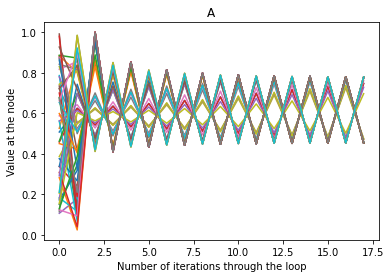

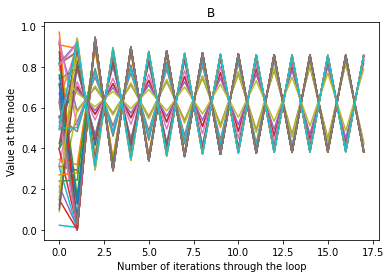

In [74]:
for node in N.biological_nodes:
    plt.figure()
    plot_node_results(N, states_negative, node)
    #plt.ylim((0,1))
    plt.title(node)

In [75]:
oscillatory_params = utils.obtain_params(N)

In [76]:
oscillatory_params

({('A', 'B'): [1.423401793239488, -0.6767678701218874],
  ('B', 'NOT'): [0.5914086562357377, -0.25943296986348574]},
 [4.1512180335497675, 1.8065314056074064],
 [0.5082570933652978, 0.7714889192684334])

In [77]:
#pickle.dump(oscillatory_params, open("oscillatory_params.p", "wb"))

## A bigger oscillatory loop
({('A', 'AND'): [-0.504558949813789, -0.9106456416774577],
  ('B', 'C'): [1.423401793239488, -0.6767678701218874],
  ('C', 'NOT'): [0.5914086562357377, -0.25943296986348574]},
 [0.6037718103806341, 4.1512180335497675, 1.8065314056074064],
 [0.4022644214971113, 0.5082570933652978, 0.7714889192684334])
 
 **The point of this loop is that there is a root node so the input is more straightforward. Note that the behevior depends on the stimulation value**

In [83]:
N_big = create_neg_loop()
N_big.edges()[("B", "C")]["layer"].n = torch.nn.Parameter(torch.tensor(1.423401793239488))
N_big.edges()[("B", "C")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.6767678701218874))
N_big.edges()[("C", "NOT")]["layer"].n = torch.nn.Parameter(torch.tensor(0.5914086562357377))
N_big.edges()[("C", "NOT")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.25943296986348574))
N_big.edges()[("A", "AND")]["layer"].n = torch.nn.Parameter(torch.tensor(-0.504558949813789))
N_big.edges()[("A", "AND")]["layer"].K = torch.nn.Parameter(torch.tensor( -0.9106456416774577))


N_big.initialise_random_truth_and_output(15)
N_big.set_network_ground_truth({"A":torch.rand(15), "B":torch.rand(15), "C":torch.rand(15)})
for node in N_big.biological_nodes:
    N_big.nodes()[node]["output_state"] = N_big.nodes()[node]["ground_truth"] 
states_negative = N_big.sequential_update(["A"], convergence_check = True)

/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


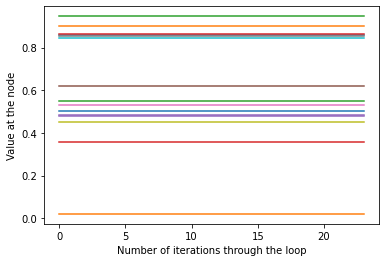

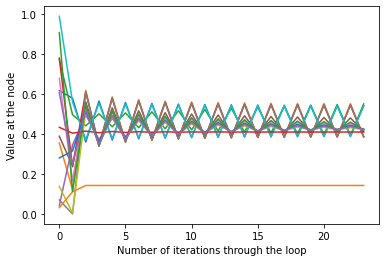

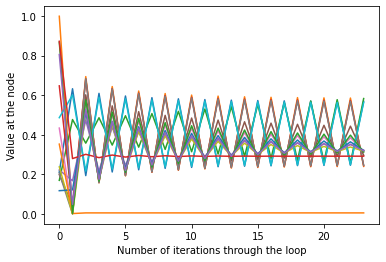

In [84]:
for node in N_big.biological_nodes:
    plt.figure()
    plot_node_results(N_big, states_negative, node)
    #plt.ylim((0,1))


In [80]:
oscill_params_big = utils.obtain_params(N_big)

In [81]:
oscill_params_big

({('A', 'AND'): [-0.504558949813789, -0.9106456416774577],
  ('B', 'C'): [1.423401793239488, -0.6767678701218874],
  ('C', 'NOT'): [0.5914086562357377, -0.25943296986348574]},
 [0.6037718103806341, 4.1512180335497675, 1.8065314056074064],
 [0.4022644214971113, 0.5082570933652978, 0.7714889192684334])

In [82]:
#pickle.dump(oscill_params_big, open("loops/oscillatory_params_big_loop.p", "wb"))

## A bistable positive  loop

({('A', 'B'): [0.6080123477547604, -1.0433492801100686],
  ('B', 'A'): [0.499241513702521, -0.44126596346853575]},
 [1.836776894324807, 1.647471212343937],
 [0.3522728434815276, 0.6432216103707636])

In [85]:
P = create_small_pos_loop()
P.initialise_random_truth_and_output(50)
P.edges()[("A", "B")]["layer"].n = torch.nn.Parameter(torch.tensor(0.6080123477547604))
P.edges()[("A", "B")]["layer"].K = torch.nn.Parameter(torch.tensor(-1.0433492801100686))
P.edges()[("B", "A")]["layer"].n = torch.nn.Parameter(torch.tensor(0.499241513702521))
P.edges()[("B", "A")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.44126596346853575))


P.set_network_ground_truth({"A":torch.rand(50), "B":torch.rand(50)})
for node in P.biological_nodes:
    P.nodes()[node]["output_state"] = P.nodes()[node]["ground_truth"] 
states_positive = P.sequential_update(["A"], convergence_check = True)


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:102: UserWarning: No root nodes in the network, most probably due to a loop. Be sure to specify input nodes for optimisation.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


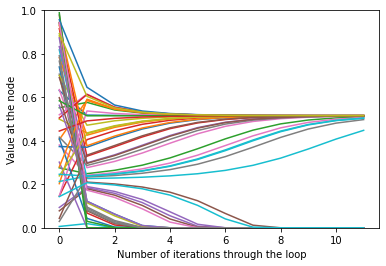

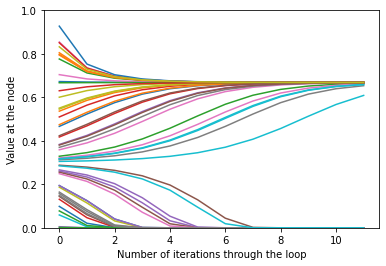

In [86]:
for node in P.biological_nodes:
    plt.figure()
    plot_node_results(P, states_positive, node)
    plt.ylim((0,1))


In [19]:
bistability_params = utils.obtain_params(P)

In [20]:
bistability_params

({('A', 'B'): [0.6080123477547604, -1.0433492801100686],
  ('B', 'A'): [0.499241513702521, -0.44126596346853575]},
 [1.836776894324807, 1.647471212343937],
 [0.3522728434815276, 0.6432216103707636])

In [21]:
#pickle.dump(bistability_params, open("bistability_params.p", "wb"))

## A bigger bistable loop

({('A', 'OR'): [1.5853397866217094, 0.1954952050293041],
  ('B', 'C'): [0.6080123477547604, -1.0433492801100686],
  ('C', 'OR'): [0.499241513702521, -0.44126596346853575]},[4.880949578147644, 1.836776894324807, 1.647471212343937],
 [1.2159129636411636, 0.3522728434815276, 0.6432216103707636] )
 
 **Also easier to fit because of the root node: groudn truth for input parameter is more straightforward**

In [22]:
P_big = create_pos_loop()
P_big.initialise_random_truth_and_output(100)
P_big.edges()[("B", "C")]["layer"].n = torch.nn.Parameter(torch.tensor(0.6080123477547604))
P_big.edges()[("B", "C")]["layer"].K = torch.nn.Parameter(torch.tensor(-1.0433492801100686))
P_big.edges()[("C", "OR")]["layer"].n = torch.nn.Parameter(torch.tensor(0.499241513702521))
P_big.edges()[("C", "OR")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.44126596346853575))
P_big.edges()[("A", "OR")]["layer"].n = torch.nn.Parameter(torch.tensor(1.5853397866217094))
P_big.edges()[("A", "OR")]["layer"].K = torch.nn.Parameter(torch.tensor(0.1954952050293041))

P_big.set_network_ground_truth({"A":torch.rand(100), "B":torch.rand(100), "C":torch.rand(100)})
for node in P_big.biological_nodes:
    P_big.nodes()[node]["output_state"] = P_big.nodes()[node]["ground_truth"] 
states_positive = P_big.sequential_update(["A"], convergence_check = True)



/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


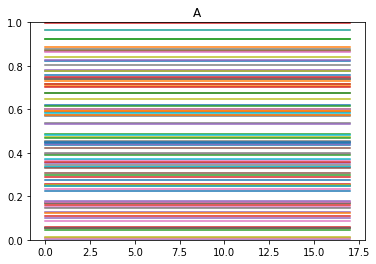

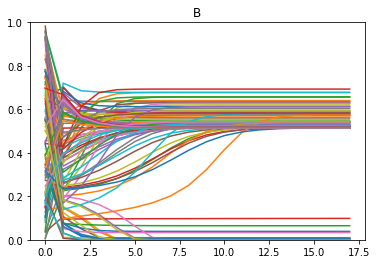

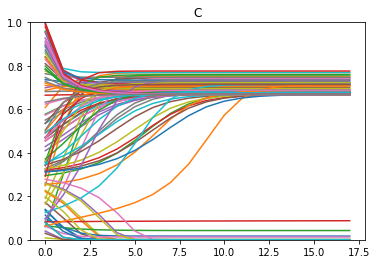

In [23]:
for node in P_big.biological_nodes:
    plt.figure()
    plot_node_results(P_big, states_positive, node)
    plt.ylim((0,1))
    plt.title(node)

In [24]:
bistable_big_params = ({('A', 'OR'): [1.5853397866217094, 0.1954952050293041],
  ('B', 'C'): [0.6080123477547604, -1.0433492801100686],
  ('C', 'OR'): [0.499241513702521, -0.44126596346853575]},[4.880949578147644, 1.836776894324807, 1.647471212343937],
 [1.2159129636411636, 0.3522728434815276, 0.6432216103707636] )

In [25]:
#pickle.dump(bistable_big_params, open("loops/bistability_params_big_loop.p", "wb"))

# Try to fit BioFuzzNets to those bigger oscillatory and bistable loops

## Positive bistable loop

In [36]:
P_big.initialise_random_truth_and_output(1000)
P_big.set_network_ground_truth({"A":torch.rand(1000), "B":torch.rand(1000), "C":torch.rand(1000)})
for node in P_big.biological_nodes:
    P_big.nodes()[node]["output_state"] = P_big.nodes()[node]["ground_truth"] 
states_positive_train = P_big.sequential_update(["A"], convergence_check = True)


P_big.initialise_random_truth_and_output(100)
P_big.set_network_ground_truth({"A":torch.rand(100), "B":torch.rand(100), "C":torch.rand(100)})
for node in P_big.biological_nodes:
    P_big.nodes()[node]["output_state"] = P_big.nodes()[node]["ground_truth"] 
states_positive_test = P_big.sequential_update(["A"], convergence_check = True)


ground_truth_pos = states_positive_train[15]
ground_truth_test_pos = states_positive_test[15]

/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


In [37]:
test_pos = create_pos_loop()
losses = test_pos.conduct_optimisation(
        ground_truth=ground_truth_pos,
        input = {"A": ground_truth_pos["A"]},
        test_ground_truth=ground_truth_test_pos,
        test_input= {"A": ground_truth_test_pos["A"]},
        epochs = 100,
        learning_rate=5e-3,
        batch_size = 100
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:21<00:00,  2.61s/it]


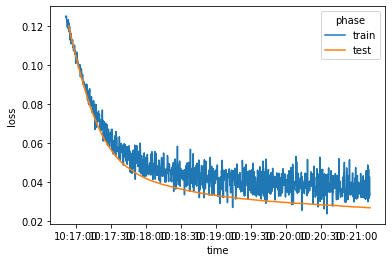

In [38]:
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()

## Negative oscillating loop

In [39]:
N_big.initialise_random_truth_and_output(100)
N_big.set_network_ground_truth({"A":torch.rand(100), "B":torch.rand(100), "C":torch.rand(100)})
for node in N_big.biological_nodes:
    N_big.nodes()[node]["output_state"] = P_big.nodes()[node]["ground_truth"] 
states_negative_test = N_big.sequential_update(["A"], convergence_check = True)



N_big.initialise_random_truth_and_output(1000)
N_big.set_network_ground_truth({"A":torch.rand(1000), "B":torch.rand(1000), "C":torch.rand(1000)})
for node in N_big.biological_nodes:
    N_big.nodes()[node]["output_state"] = P_big.nodes()[node]["ground_truth"] 
states_negative_train = N_big.sequential_update(["A"], convergence_check = True)


ground_truth_neg = states_negative_train[15]
ground_truth_test_neg = states_negative_test[15]

/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


In [40]:
test_neg = create_neg_loop()
losses = test_neg.conduct_optimisation(
        ground_truth=ground_truth_neg,
        input = {"A": ground_truth_neg["A"]},
        test_ground_truth=ground_truth_test_neg,
        test_input= {"A": ground_truth_test_neg["A"]},
        epochs = 50,
        learning_rate=5e-3,
        batch_size = 100
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:32<00:00,  3.06s/it]


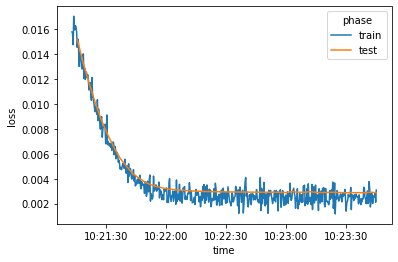

In [41]:
sns.lineplot(data=losses, x="time", y="loss", hue="phase")
plt.show()

### What are the outputs

In [43]:
def compute_RMSE(predictions, ground_truth, nodes):
    """
    Compute the RMSE
    """
    rmse = {}
    for node in nodes:
        rmse[node] = torch.sqrt(
            torch.sum(
                (predictions[node] - ground_truth[node]) ** 2
            )
            / len(predictions[node])
        ).item()
    node = max(rmse, key=rmse.get)
    
    return rmse

In [44]:
compute_RMSE(test_neg.output_states, ground_truth_test_neg, ["B", "C"])

{'B': 0.041412846475879034, 'C': 0.08304874482591472}

In [45]:
# positive loop
compute_RMSE(test_pos.output_states, ground_truth_test_pos, ["B", "C"])

{'B': 0.17225721331985316, 'C': 0.22505664972815653}

## Examine sensitivity of loop behavior to parameter

In [47]:
# Negative loop
oscill_params_big

({('A', 'AND'): [-0.504558949813789, -0.9106456416774577],
  ('B', 'C'): [1.423401793239488, -0.6767678701218874],
  ('C', 'NOT'): [0.5914086562357377, -0.25943296986348574]},
 [0.6037718103806341, 4.1512180335497675, 1.8065314056074064],
 [0.4022644214971113, 0.5082570933652978, 0.7714889192684334])

(array([  4.,  11.,  39., 123., 190., 259., 200., 113.,  50.,  11.]),
 array([-0.33469972, -0.27419631, -0.2136929 , -0.15318949, -0.09268609,
        -0.03218268,  0.02832073,  0.08882413,  0.14932754,  0.20983095,
         0.27033436]),
 <BarContainer object of 10 artists>)

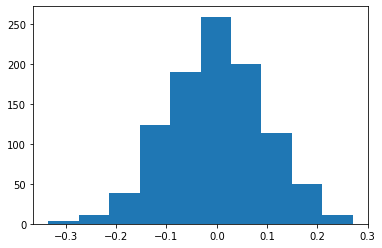

In [65]:
plt.hist(torch.normal(0, 0.1,size =(1, 1000)))

---------------------------------------
FOLD0


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


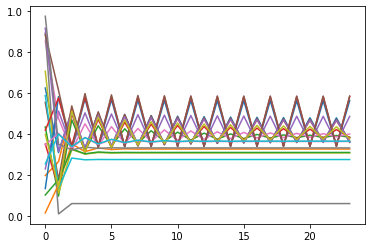

------------------------------------------
---------------------------------------
FOLD1


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


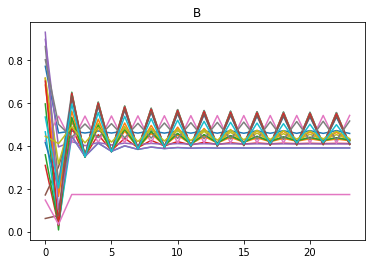

------------------------------------------
---------------------------------------
FOLD2


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


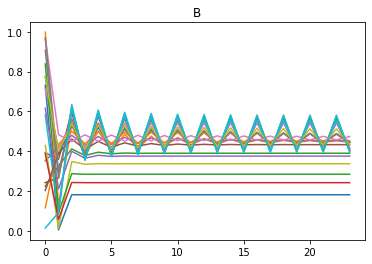

------------------------------------------
---------------------------------------
FOLD3


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


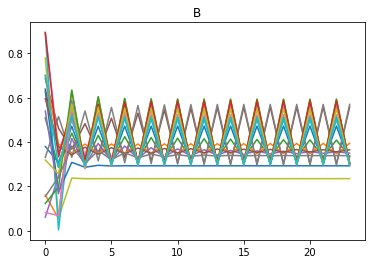

------------------------------------------
---------------------------------------
FOLD4


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


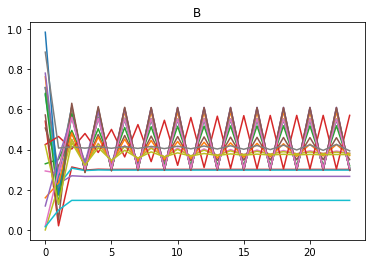

------------------------------------------
---------------------------------------
FOLD5


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


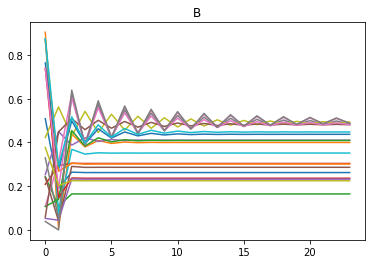

------------------------------------------
---------------------------------------
FOLD6


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


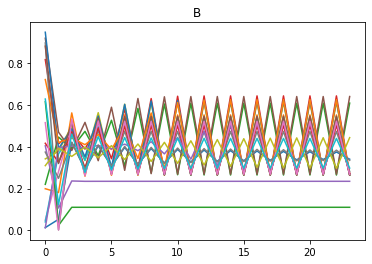

------------------------------------------
---------------------------------------
FOLD7


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


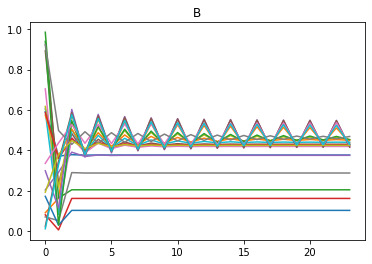

------------------------------------------
---------------------------------------
FOLD8


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


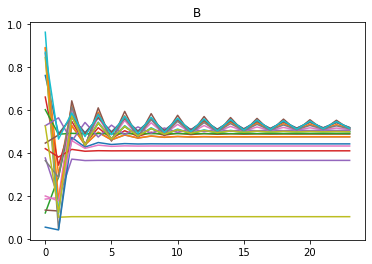

------------------------------------------
---------------------------------------
FOLD9


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


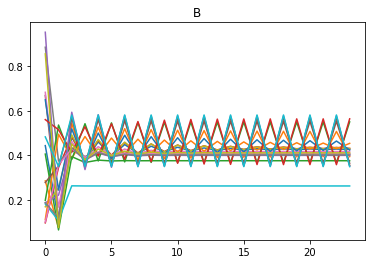

------------------------------------------
---------------------------------------
FOLD10


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


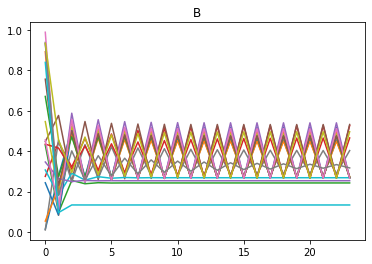

------------------------------------------
---------------------------------------
FOLD11


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


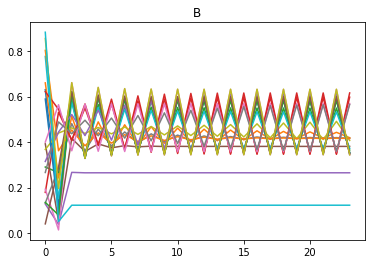

------------------------------------------
---------------------------------------
FOLD12


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


KeyboardInterrupt: 

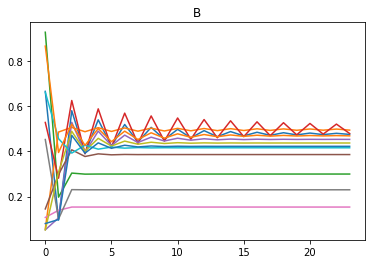

In [66]:
for i in range(50):
    loop = create_neg_loop()
    perturbation = torch.normal(0, 0.1,size =(1, 6))[0]
    
    loop.edges()[("B", "C")]["layer"].n = torch.nn.Parameter(torch.tensor(1.423401793239488)+perturbation[0])
    loop.edges()[("B", "C")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.6767678701218874)+perturbation[1])
    loop.edges()[("C", "NOT")]["layer"].n = torch.nn.Parameter(torch.tensor(0.5914086562357377)+perturbation[2])
    loop.edges()[("C", "NOT")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.25943296986348574)+perturbation[3])
    loop.edges()[("A", "AND")]["layer"].n = torch.nn.Parameter(torch.tensor(-0.504558949813789)+perturbation[4])
    loop.edges()[("A", "AND")]["layer"].K = torch.nn.Parameter(torch.tensor( -0.9106456416774577)+perturbation[5])
    
    print("---------------------------------------")
    print(f"FOLD{i}")
    loop.initialise_random_truth_and_output(20)
    loop.set_network_ground_truth({"A":torch.rand(20), "B":torch.rand(20), "C":torch.rand(20)})
    for node in loop.biological_nodes:
        loop.nodes()[node]["output_state"] = loop.nodes()[node]["ground_truth"] 
    states_negative = loop.sequential_update(["A"], convergence_check = True)
    for node in ["B"]:
        plot_node_results(loop, states_negative, node)
        plt.show()
        plt.title(node)
    print("------------------------------------------")

In [63]:
plt.close("all")

---------------------------------------
FOLD0


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


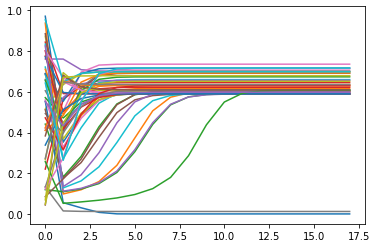

------------------------------------------
---------------------------------------
FOLD1


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


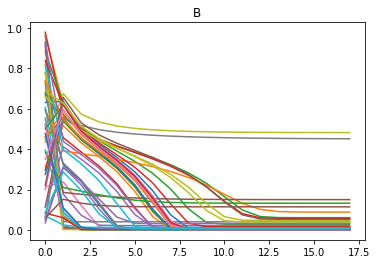

------------------------------------------
---------------------------------------
FOLD2


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


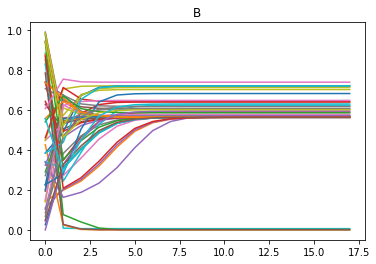

------------------------------------------
---------------------------------------
FOLD3


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


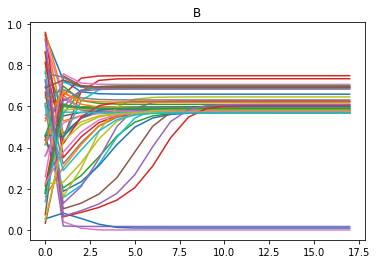

------------------------------------------
---------------------------------------
FOLD4


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


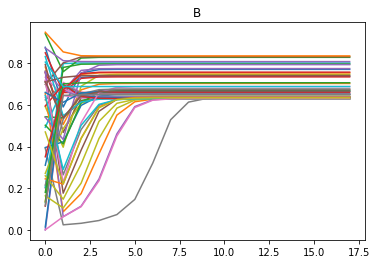

------------------------------------------
---------------------------------------
FOLD5


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


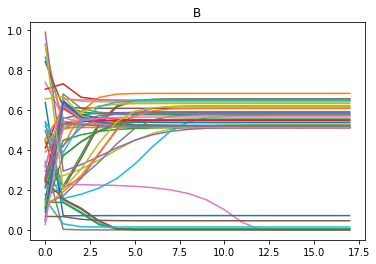

------------------------------------------
---------------------------------------
FOLD6


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


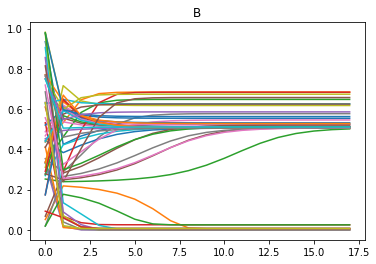

------------------------------------------
---------------------------------------
FOLD7


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


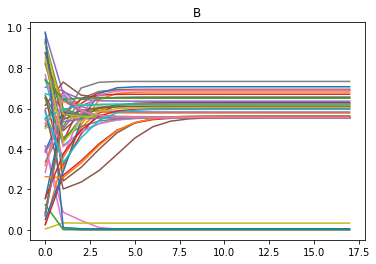

------------------------------------------
---------------------------------------
FOLD8


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


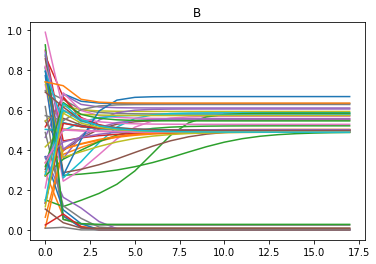

------------------------------------------
---------------------------------------
FOLD9


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


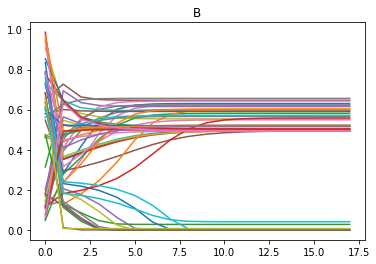

------------------------------------------
---------------------------------------
FOLD10


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


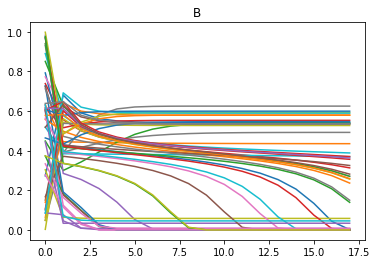

------------------------------------------
---------------------------------------
FOLD11


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


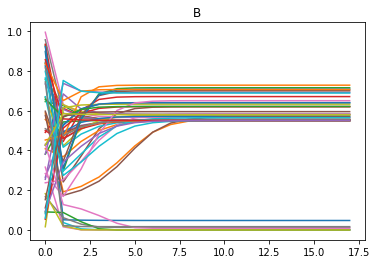

------------------------------------------
---------------------------------------
FOLD12


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


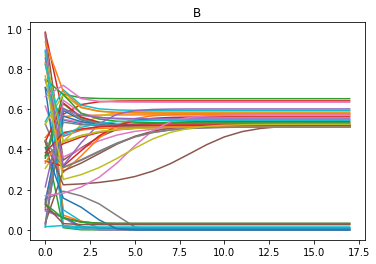

------------------------------------------
---------------------------------------
FOLD13


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


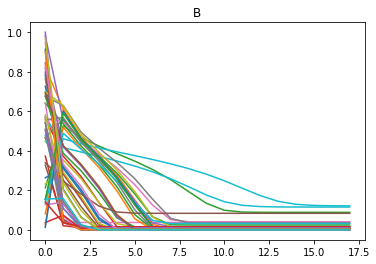

------------------------------------------
---------------------------------------
FOLD14


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


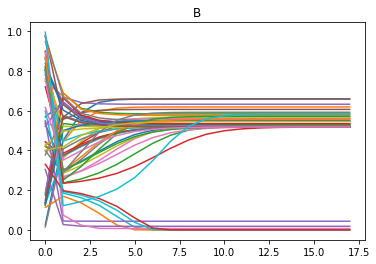

------------------------------------------
---------------------------------------
FOLD15


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


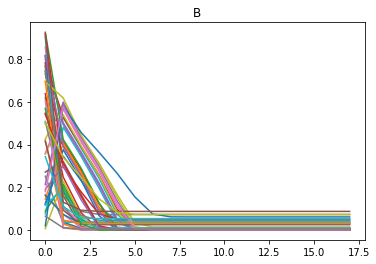

------------------------------------------
---------------------------------------
FOLD16


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


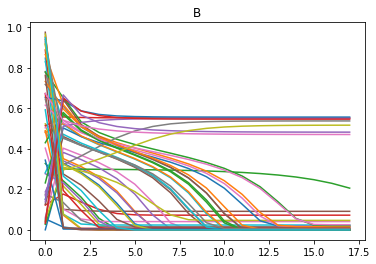

------------------------------------------
---------------------------------------
FOLD17


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


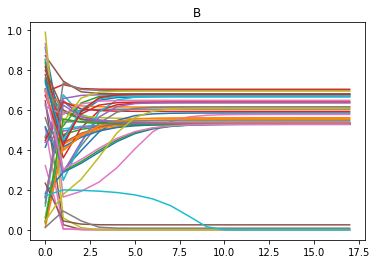

------------------------------------------
---------------------------------------
FOLD18


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


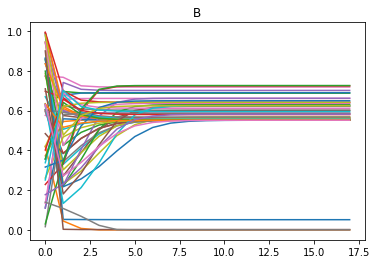

------------------------------------------
---------------------------------------
FOLD19


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


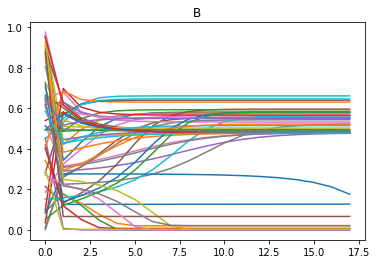

------------------------------------------
---------------------------------------
FOLD20


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


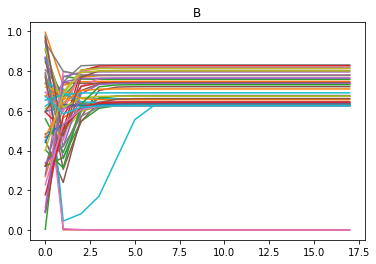

------------------------------------------
---------------------------------------
FOLD21


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


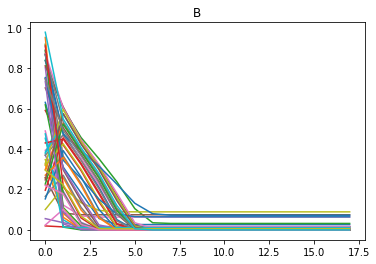

------------------------------------------
---------------------------------------
FOLD22


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


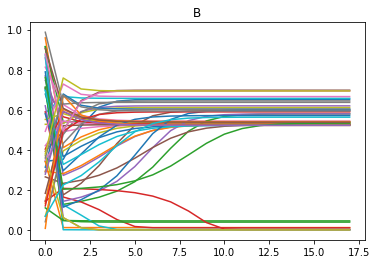

------------------------------------------
---------------------------------------
FOLD23


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


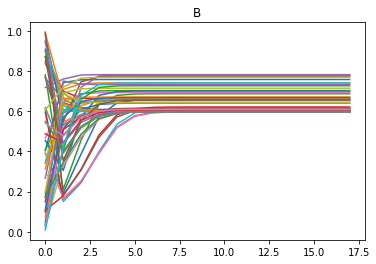

------------------------------------------
---------------------------------------
FOLD24


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


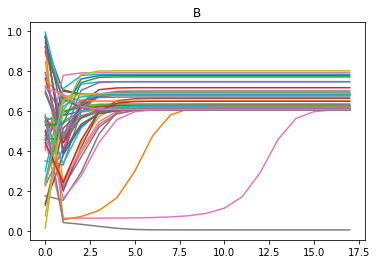

------------------------------------------
---------------------------------------
FOLD25


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


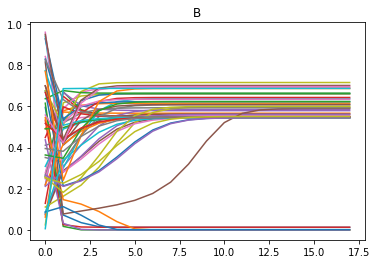

------------------------------------------
---------------------------------------
FOLD26


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


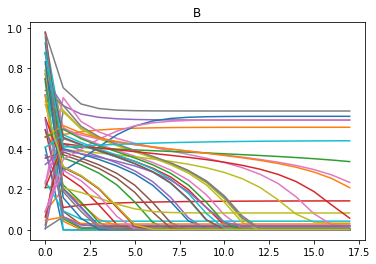

------------------------------------------
---------------------------------------
FOLD27


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


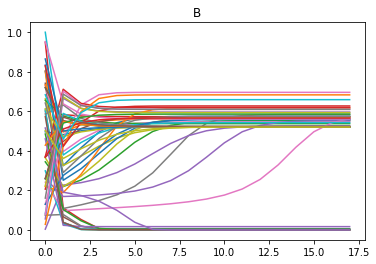

------------------------------------------
---------------------------------------
FOLD28


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


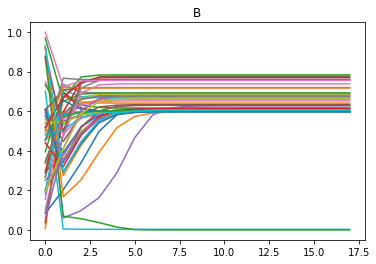

------------------------------------------
---------------------------------------
FOLD29


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


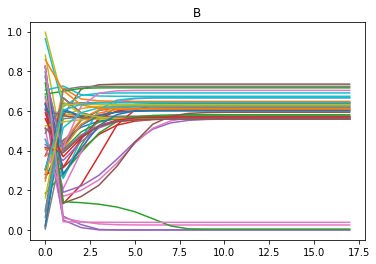

------------------------------------------
---------------------------------------
FOLD30


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


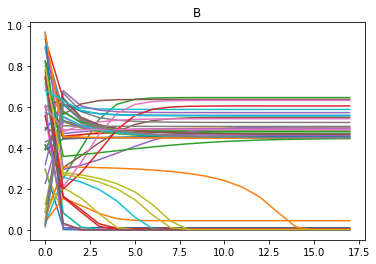

------------------------------------------
---------------------------------------
FOLD31


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


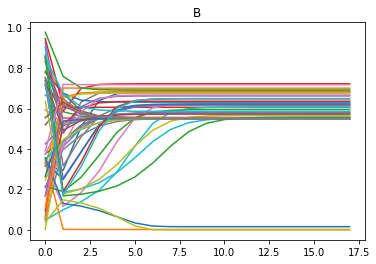

------------------------------------------
---------------------------------------
FOLD32


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


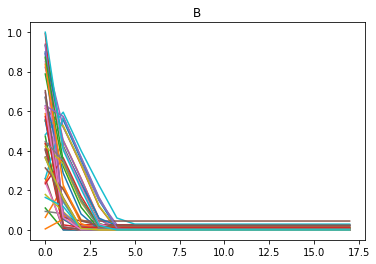

------------------------------------------
---------------------------------------
FOLD33


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


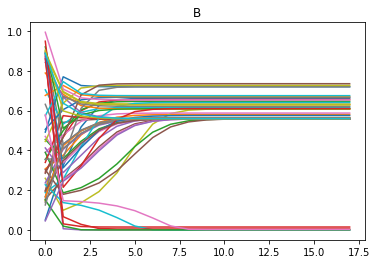

------------------------------------------
---------------------------------------
FOLD34


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


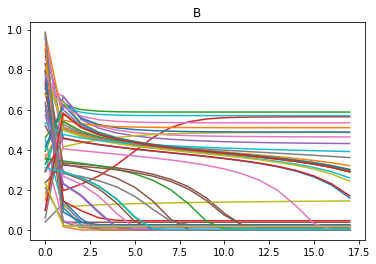

------------------------------------------
---------------------------------------
FOLD35


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


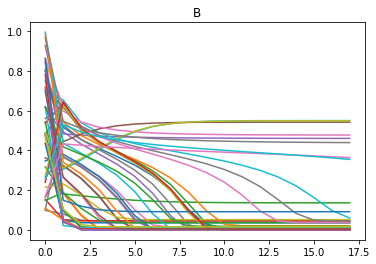

------------------------------------------
---------------------------------------
FOLD36


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


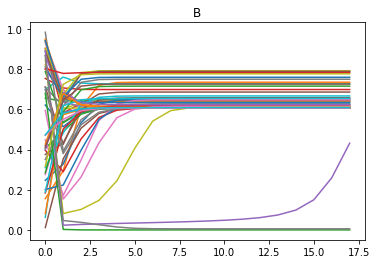

------------------------------------------
---------------------------------------
FOLD37


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


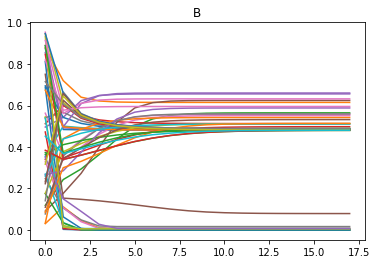

------------------------------------------
---------------------------------------
FOLD38


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


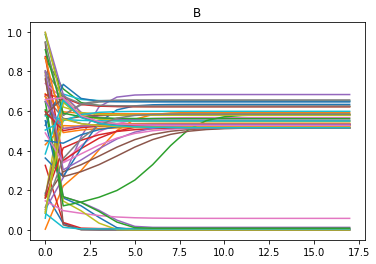

------------------------------------------
---------------------------------------
FOLD39


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


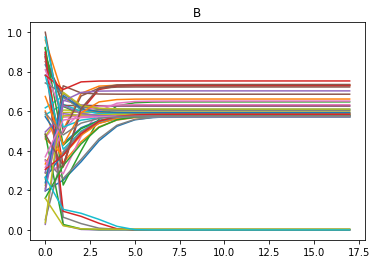

------------------------------------------
---------------------------------------
FOLD40


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


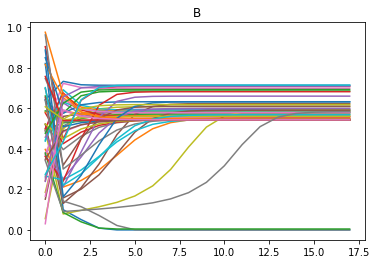

------------------------------------------
---------------------------------------
FOLD41


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


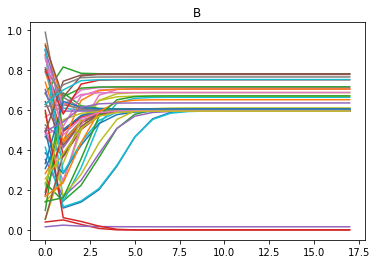

------------------------------------------
---------------------------------------
FOLD42


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


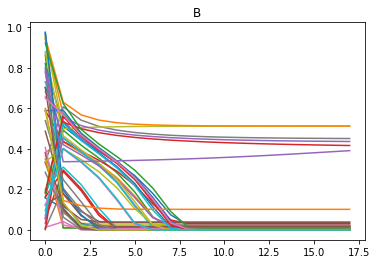

------------------------------------------
---------------------------------------
FOLD43


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


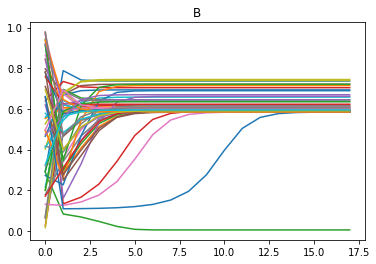

------------------------------------------
---------------------------------------
FOLD44


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


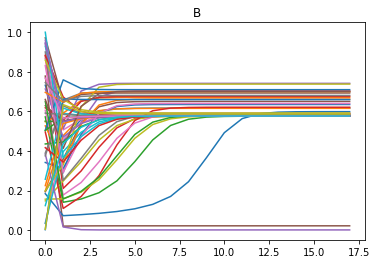

------------------------------------------
---------------------------------------
FOLD45


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


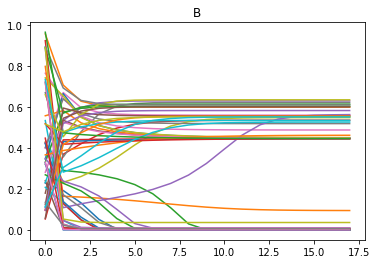

------------------------------------------
---------------------------------------
FOLD46


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


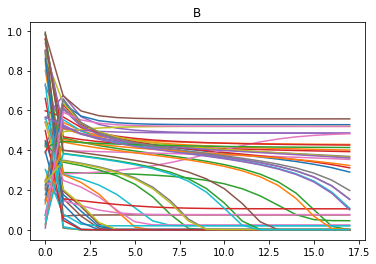

------------------------------------------
---------------------------------------
FOLD47


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


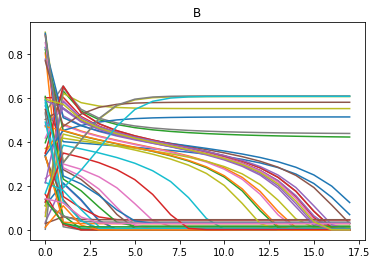

------------------------------------------
---------------------------------------
FOLD48


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


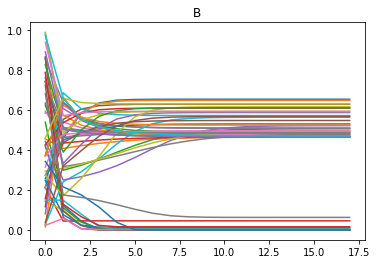

------------------------------------------
---------------------------------------
FOLD49


/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:585: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(
/home/ubuntu/storage/BioNICs/bionics/biofuzznet/biofuzznet.py:520: UserWarning: convergence_check has been set to True. All simulation states will be saved and returned. This has not been optimised for memory usage and is implemented in a naive manner. Proceed with caution.
  warnings.warn(


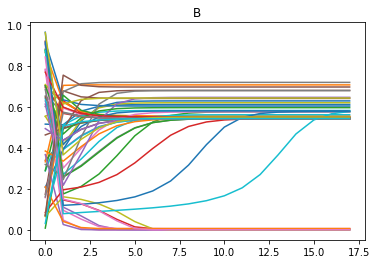

------------------------------------------


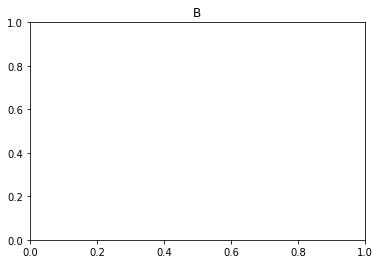

In [68]:
for i in range(50):
    loop = create_pos_loop()
    perturbation = torch.normal(0, 0.1,size =(1, 6))[0]
    
    loop.edges()[("B", "C")]["layer"].n = torch.nn.Parameter(torch.tensor(0.6080123477547604) + perturbation[0])
    loop.edges()[("B", "C")]["layer"].K = torch.nn.Parameter(torch.tensor(-1.0433492801100686)+ perturbation[0])
    loop.edges()[("C", "OR")]["layer"].n = torch.nn.Parameter(torch.tensor(0.499241513702521)+ perturbation[0])
    loop.edges()[("C", "OR")]["layer"].K = torch.nn.Parameter(torch.tensor(-0.44126596346853575)+ perturbation[0])
    loop.edges()[("A", "OR")]["layer"].n = torch.nn.Parameter(torch.tensor(1.5853397866217094)+ perturbation[0])
    loop.edges()[("A", "OR")]["layer"].K = torch.nn.Parameter(torch.tensor(0.1954952050293041)+ perturbation[0])


    print("---------------------------------------")
    print(f"FOLD{i}")
    loop.initialise_random_truth_and_output(50)
    loop.set_network_ground_truth({"A":torch.rand(50), "B":torch.rand(50), "C":torch.rand(50)})
    for node in loop.biological_nodes:
        loop.nodes()[node]["output_state"] = loop.nodes()[node]["ground_truth"] 
    states_negative = loop.sequential_update(["A"], convergence_check = True)
    for node in ["B"]:
        plot_node_results(loop, states_negative, node)
        plt.show()
        plt.title(node)
    print("------------------------------------------")

In [69]:
plt.close("all")